# 使用Chronos的时间序列Transformers

In [14]:
%pip install 'chronos-forecasting>=2.1' 'pandas[pyarrow]' 'matplotlib'

Note: you may need to restart the kernel to use updated packages.


In [15]:
import os

# Use only 1 GPU if available
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline, Chronos2Pipeline

# Load the Chronos-2 pipeline
# GPU recommended for faster inference, but CPU is also supported
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cpu")

In [16]:
context_df = pd.read_excel("/Users/1m/Desktop/大三上/大数据/期末/data.xlsx", header=1)
context_df.columns = context_df.columns.str.strip()
print("Input dataframe shape:", context_df.shape)
print("\n列名:", context_df.columns.tolist())

# 检查并统一日期列名
if 'Date' in context_df.columns and 'timestamp' not in context_df.columns:
    context_df['timestamp'] = pd.to_datetime(context_df['Date'])
    print("\n已将'Date'列转换为'timestamp'列")
elif 'timestamp' in context_df.columns:
    context_df['timestamp'] = pd.to_datetime(context_df['timestamp'])
    print("\n'timestamp'列已存在，已转换为datetime类型")
else:
    print("\n警告：未找到'Date'或'timestamp'列，请检查数据格式")

# 检查目标列
if 'Number of  reported results' in context_df.columns:
    context_df['target'] = context_df['Number of  reported results']
    print("已将'Number of  reported results'列映射为'target'列")
elif 'target' not in context_df.columns:
    print("\n警告：未找到目标列，请手动指定")

display(context_df.head())

Input dataframe shape: (359, 14)

列名: ['Unnamed: 0', 'Date', 'Contest number', 'Word', 'Number of  reported results', 'Number in hard mode', '1 try', '2 tries', '3 tries', '4 tries', '5 tries', '6 tries', '7 or more tries (X)', 'sum']

已将'Date'列转换为'timestamp'列
已将'Number of  reported results'列映射为'target'列


,Unnamed: 0,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),sum,timestamp,target
0,NaN,2022-12-31,560,manly,20380,1899,0,2,17,37,29,12,2,99,2022-12-31,20380
1,NaN,2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1,99,2022-12-30,21204
2,NaN,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2,100,2022-12-29,20001
3,NaN,2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1,99,2022-12-28,20160
4,NaN,2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3,100,2022-12-27,20879


In [17]:
# 数据需要重新组织：将整个数据视为单一时间序列
# 首先按时间排序，然后创建单一序列格式

# 检查必要的列是否存在
required_cols = ['timestamp', 'target']
missing_cols = [col for col in required_cols if col not in context_df.columns]
if missing_cols:
    raise ValueError(f"缺少必要的列: {missing_cols}。请先运行上一个cell进行数据预处理。")

# 按时间排序（从早到晚）
context_df_sorted = context_df.sort_values('timestamp').reset_index(drop=True)

# 创建适合 Chronos-2 的数据格式：单一时间序列
# 使用固定的 item_id 表示这是同一个序列
ts_df = pd.DataFrame({
    'timestamp': context_df_sorted['timestamp'],
    'item_id': 1,  # 所有数据点属于同一个序列
    'target': context_df_sorted['target']  # 预测目标列
})

print("重新组织后的数据:")
print(f"时间范围: {ts_df['timestamp'].min()} 到 {ts_df['timestamp'].max()}")
print(f"数据点数: {len(ts_df)}")
display(ts_df.head())

重新组织后的数据:
时间范围: 2022-01-07 00:00:00 到 2022-12-31 00:00:00
数据点数: 359


,timestamp,item_id,target
0,2022-01-07,1,80630
1,2022-01-08,1,101503
2,2022-01-09,1,91477
3,2022-01-10,1,107134
4,2022-01-11,1,153880


In [18]:
# 使用 Chronos-2 进行预测
# 计算两个置信区间: 80% (0.1-0.9), 90% (0.05-0.95)
pred_df = pipeline.predict_df(
    ts_df, 
    prediction_length=60, 
    quantile_levels=[0.05, 0.1, 0.5, 0.9, 0.95],
    id_column='item_id',
    timestamp_column='timestamp',
    target='target'
)

print("预测结果:")
print("Output dataframe shape:", pred_df.shape)
print("\n分位数列说明:")
print("  - 0.05 & 0.95: 90% 置信区间")
print("  - 0.1 & 0.9: 80% 置信区间")
print("  - 0.5: 中位数")
display(pred_df.head(10))

/Users/1m/Desktop/大三上/大数据/期末/coding/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


预测结果:
Output dataframe shape: (60, 9)

分位数列说明:
  - 0.05 & 0.95: 90% 置信区间
  - 0.1 & 0.9: 80% 置信区间
  - 0.5: 中位数


,item_id,timestamp,target_name,predictions,0.05,0.1,0.5,0.9,0.95
0,1,2023-01-01,target,20664.226562,18554.656250,18988.585938,20664.226562,22092.546875,22550.492188
1,1,2023-01-02,target,20682.515625,18639.703125,19002.601562,20682.515625,22337.765625,22728.390625
2,1,2023-01-03,target,20623.687500,18344.734375,18837.218750,20623.687500,22052.007812,22434.625000
3,1,2023-01-04,target,20417.351562,18272.343750,18748.031250,20417.351562,21812.765625,22462.296875
4,1,2023-01-05,target,19869.375000,17962.226562,18631.578125,19869.375000,21732.375000,22198.257812
5,1,2023-01-06,target,20101.648438,17909.914062,18358.000000,20101.648438,21569.296875,22267.898438
6,1,2023-01-07,target,19924.828125,17735.546875,18266.851562,19924.828125,21208.234375,21738.007812
7,1,2023-01-08,target,19603.820312,17558.796875,18148.289062,19603.820312,21171.015625,21648.906250
8,1,2023-01-09,target,19408.945312,17488.968750,17950.757812,19408.945312,21215.515625,21867.078125
9,1,2023-01-10,target,19806.843750,17491.781250,17953.937500,19806.843750,21394.742188,22396.601562


In [19]:
# 使用 Chronos-2 进行预测
# 计算两个置信区间: 80% (0.1-0.9), 90% (0.05-0.95)
pred_df = pipeline.predict_df(
    ts_df, 
    prediction_length=60, 
    quantile_levels=[0.05, 0.1, 0.5, 0.9, 0.95],
    id_column='item_id',
    timestamp_column='timestamp',
    target='target'
)

print("预测结果:")
print("Output dataframe shape:", pred_df.shape)
print("\n分位数列说明:")
print("  - 0.05 & 0.95: 90% 置信区间")
print("  - 0.1 & 0.9: 80% 置信区间")
print("  - 0.5: 中位数")
display(pred_df.head(10))

预测结果:
Output dataframe shape: (60, 9)

分位数列说明:
  - 0.05 & 0.95: 90% 置信区间
  - 0.1 & 0.9: 80% 置信区间
  - 0.5: 中位数


/Users/1m/Desktop/大三上/大数据/期末/coding/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


,item_id,timestamp,target_name,predictions,0.05,0.1,0.5,0.9,0.95
0,1,2023-01-01,target,20664.226562,18554.656250,18988.585938,20664.226562,22092.546875,22550.492188
1,1,2023-01-02,target,20682.515625,18639.703125,19002.601562,20682.515625,22337.765625,22728.390625
2,1,2023-01-03,target,20623.687500,18344.734375,18837.218750,20623.687500,22052.007812,22434.625000
3,1,2023-01-04,target,20417.351562,18272.343750,18748.031250,20417.351562,21812.765625,22462.296875
4,1,2023-01-05,target,19869.375000,17962.226562,18631.578125,19869.375000,21732.375000,22198.257812
5,1,2023-01-06,target,20101.648438,17909.914062,18358.000000,20101.648438,21569.296875,22267.898438
6,1,2023-01-07,target,19924.828125,17735.546875,18266.851562,19924.828125,21208.234375,21738.007812
7,1,2023-01-08,target,19603.820312,17558.796875,18148.289062,19603.820312,21171.015625,21648.906250
8,1,2023-01-09,target,19408.945312,17488.968750,17950.757812,19408.945312,21215.515625,21867.078125
9,1,2023-01-10,target,19806.843750,17491.781250,17953.937500,19806.843750,21394.742188,22396.601562


In [20]:
# 使用 Chronos-2 进行预测
# 计算两个置信区间: 80% (0.1-0.9), 90% (0.05-0.95)
pred_df = pipeline.predict_df(
    ts_df, 
    prediction_length=60, 
    quantile_levels=[0.05, 0.1, 0.5, 0.9, 0.95],
    id_column='item_id',
    timestamp_column='timestamp',
    target='target'
)

print("预测结果:")
print("Output dataframe shape:", pred_df.shape)
print("\n分位数列说明:")
print("  - 0.05 & 0.95: 90% 置信区间")
print("  - 0.1 & 0.9: 80% 置信区间")
print("  - 0.5: 中位数")
display(pred_df.head(10))

预测结果:
Output dataframe shape: (60, 9)

分位数列说明:
  - 0.05 & 0.95: 90% 置信区间
  - 0.1 & 0.9: 80% 置信区间
  - 0.5: 中位数


/Users/1m/Desktop/大三上/大数据/期末/coding/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


,item_id,timestamp,target_name,predictions,0.05,0.1,0.5,0.9,0.95
0,1,2023-01-01,target,20664.226562,18554.656250,18988.585938,20664.226562,22092.546875,22550.492188
1,1,2023-01-02,target,20682.515625,18639.703125,19002.601562,20682.515625,22337.765625,22728.390625
2,1,2023-01-03,target,20623.687500,18344.734375,18837.218750,20623.687500,22052.007812,22434.625000
3,1,2023-01-04,target,20417.351562,18272.343750,18748.031250,20417.351562,21812.765625,22462.296875
4,1,2023-01-05,target,19869.375000,17962.226562,18631.578125,19869.375000,21732.375000,22198.257812
5,1,2023-01-06,target,20101.648438,17909.914062,18358.000000,20101.648438,21569.296875,22267.898438
6,1,2023-01-07,target,19924.828125,17735.546875,18266.851562,19924.828125,21208.234375,21738.007812
7,1,2023-01-08,target,19603.820312,17558.796875,18148.289062,19603.820312,21171.015625,21648.906250
8,1,2023-01-09,target,19408.945312,17488.968750,17950.757812,19408.945312,21215.515625,21867.078125
9,1,2023-01-10,target,19806.843750,17491.781250,17953.937500,19806.843750,21394.742188,22396.601562


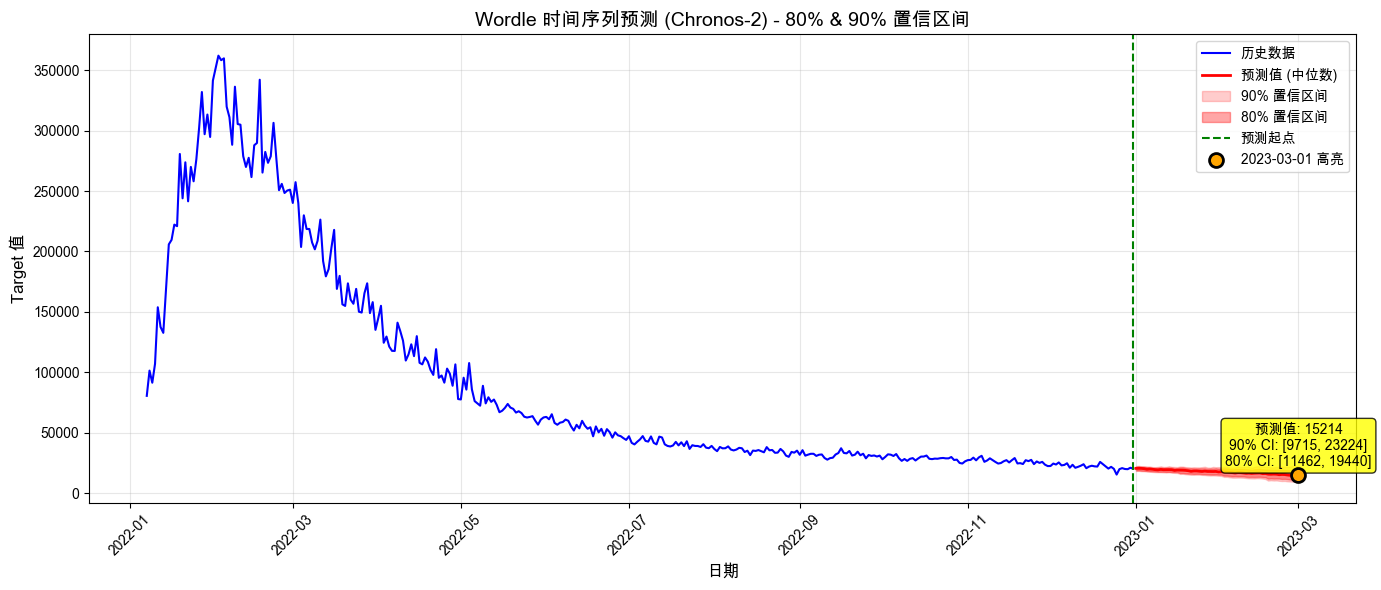

In [21]:
# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'STHeiti']  # macOS 中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 可视化：历史数据 + 预测结果（展示80%和90%置信区间）
fig, ax = plt.subplots(figsize=(14, 6))

# 绘制历史数据
ax.plot(ts_df['timestamp'], ts_df['target'], 
        label='历史数据', color='blue', linewidth=1.5)

# 绘制预测结果（中位数）
ax.plot(pred_df['timestamp'], pred_df['0.5'], 
        label='预测值 (中位数)', color='red', linewidth=2)

# 绘制两个置信区间（外到内：90% -> 80%）
# 90% 置信区间 (最外层，较浅)
ax.fill_between(pred_df['timestamp'], 
                pred_df['0.05'], 
                pred_df['0.95'],
                alpha=0.2, color='red', label='90% 置信区间')

# 80% 置信区间 (最内层，较深)
ax.fill_between(pred_df['timestamp'], 
                pred_df['0.1'], 
                pred_df['0.9'],
                alpha=0.35, color='red', label='80% 置信区间')

# 添加分割线标记预测开始点
last_historical_date = ts_df['timestamp'].iloc[-1]
ax.axvline(x=last_historical_date, color='green', linestyle='--', 
           linewidth=1.5, label='预测起点')

# 特别标出2023年3月1日的点（使用90%置信区间上下限展示）
highlight_date = pd.to_datetime('2023-03-01')
if highlight_date in pd.to_datetime(pred_df['timestamp']).values:
    highlight_value = pred_df[pred_df['timestamp'] == highlight_date]['0.5'].values[0]
    ax.scatter(highlight_date, highlight_value, color='orange', s=100, zorder=5, edgecolor='black', linewidth=2, label='2023-03-01 高亮')

    # 添加注释标出中位数和90% CI
    highlight_row = pred_df[pred_df['timestamp'] == highlight_date]
    ci90_low = highlight_row['0.05'].values[0]
    ci90_high = highlight_row['0.95'].values[0]
    ci80_low = highlight_row['0.1'].values[0]
    ci80_high = highlight_row['0.9'].values[0]
    ax.annotate(f'预测值: {highlight_value:.0f}\n90% CI: [{ci90_low:.0f}, {ci90_high:.0f}]\n80% CI: [{ci80_low:.0f}, {ci80_high:.0f}]',
                xy=(highlight_date, highlight_value), xytext=(highlight_date, highlight_value + 5000),
                ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', color='black'))
else:
    print("没有找到2023-03-01的预测结果")

ax.set_xlabel('日期', fontsize=12)
ax.set_ylabel('Target 值', fontsize=12)
ax.set_title('Wordle 时间序列预测 (Chronos-2) - 80% & 90% 置信区间', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

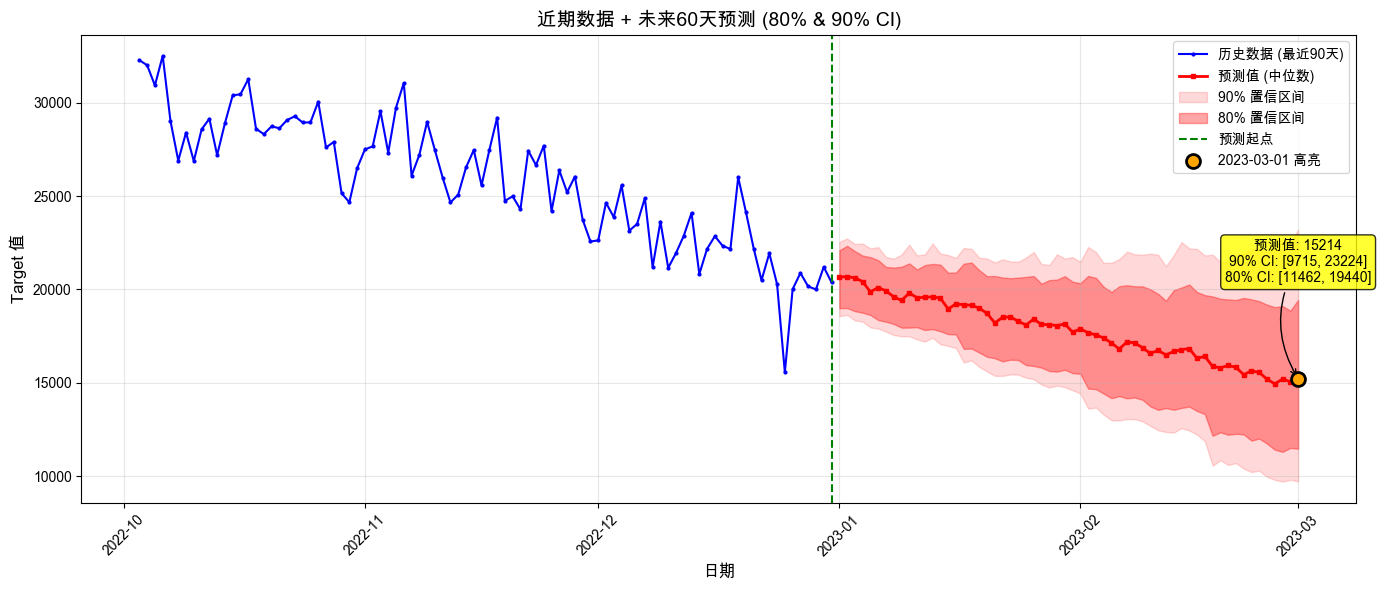


预测统计信息
预测时间范围: 2023-01-01 到 2023-03-01
预测均值范围: 14939 ~ 20683
预测中位数范围: 14939 ~ 20683

置信区间统计 (以2023-03-01为例):
  中位数预测: 15214
  80% 置信区间: [11462, 19440] (宽度: 7978)
  90% 置信区间: [9715, 23224] (宽度: 13509)

平均置信区间宽度:
  80% 置信区间: 5226
  90% 置信区间: 7709


In [22]:
# 详细展示：放大预测区域 + 置信区间对比
fig, ax = plt.subplots(figsize=(14, 6))

# 只显示最近90天历史数据 + 预测（多置信区间）
recent_days = 90
recent_ts_df = ts_df.tail(recent_days)

ax.plot(recent_ts_df['timestamp'], recent_ts_df['target'], 
    label='历史数据 (最近90天)', color='blue', linewidth=1.5, marker='o', markersize=2)
ax.plot(pred_df['timestamp'], pred_df['0.5'], 
    label='预测值 (中位数)', color='red', linewidth=2, marker='s', markersize=3)

# 90% 置信区间
ax.fill_between(pred_df['timestamp'], 
        pred_df['0.05'], pred_df['0.95'],
        alpha=0.15, color='red', label='90% 置信区间')
# 80% 置信区间
ax.fill_between(pred_df['timestamp'], 
        pred_df['0.1'], pred_df['0.9'],
        alpha=0.35, color='red', label='80% 置信区间')

ax.axvline(x=last_historical_date, color='green', linestyle='--', linewidth=1.5, label='预测起点')

# 特别标出2023年3月1日的点（使用中位数预测值）
highlight_date = pd.to_datetime('2023-03-01')
if highlight_date in pd.to_datetime(pred_df['timestamp']).values:
    highlight_value = pred_df[pred_df['timestamp'] == highlight_date]['0.5'].values[0]
    ax.scatter(highlight_date, highlight_value, color='orange', s=100, zorder=5, edgecolor='black', linewidth=2, label='2023-03-01 高亮')

    # 添加注释标出中位数和置信区间
    highlight_row = pred_df[pred_df['timestamp'] == highlight_date]
    ci90_low = highlight_row['0.05'].values[0]
    ci90_high = highlight_row['0.95'].values[0]
    ci80_low = highlight_row['0.1'].values[0]
    ci80_high = highlight_row['0.9'].values[0]
    ax.annotate(f'预测值: {highlight_value:.0f}\n90% CI: [{ci90_low:.0f}, {ci90_high:.0f}]\n80% CI: [{ci80_low:.0f}, {ci80_high:.0f}]',
        xy=(highlight_date, highlight_value), xytext=(highlight_date, highlight_value + 5000),
        ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', color='black'))
else:
    print("没有找到2023-03-01的预测结果")

ax.set_xlabel('日期', fontsize=12)
ax.set_ylabel('Target 值', fontsize=12)
ax.set_title('近期数据 + 未来60天预测 (80% & 90% CI)', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 打印预测统计信息
print("\n" + "="*60)
print("预测统计信息")
print("="*60)
print(f"预测时间范围: {pred_df['timestamp'].min().strftime('%Y-%m-%d')} 到 {pred_df['timestamp'].max().strftime('%Y-%m-%d')}")
print(f"预测均值范围: {pred_df['predictions'].min():.0f} ~ {pred_df['predictions'].max():.0f}")
print(f"预测中位数范围: {pred_df['0.5'].min():.0f} ~ {pred_df['0.5'].max():.0f}")

print("\n置信区间统计 (以2023-03-01为例):")
target_date = pd.to_datetime('2023-03-01')
if not pred_df[pred_df['timestamp'] == target_date].empty:
    row = pred_df[pred_df['timestamp'] == target_date].iloc[0]
    print(f"  中位数预测: {row['0.5']:.0f}")
    print(f"  80% 置信区间: [{row['0.1']:.0f}, {row['0.9']:.0f}] (宽度: {row['0.9']-row['0.1']:.0f})")
    print(f"  90% 置信区间: [{row['0.05']:.0f}, {row['0.95']:.0f}] (宽度: {row['0.95']-row['0.05']:.0f})")

ci_80_width = pred_df['0.9'] - pred_df['0.1']
ci_90_width = pred_df['0.95'] - pred_df['0.05']
print("\n平均置信区间宽度:")
print(f"  80% 置信区间: {ci_80_width.mean():.0f}")
print(f"  90% 置信区间: {ci_90_width.mean():.0f}")

# 